In [1]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

2024-05-15 04:51:25.312940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 04:51:25.313063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 04:51:25.583937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

In [3]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [4]:
meta.shape

(95634, 5)

In [5]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

In [6]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [7]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [8]:
Train_set.shape,Val_set.shape,Test_set.shape

((8960, 5), (3840, 5), (3200, 5))

In [35]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

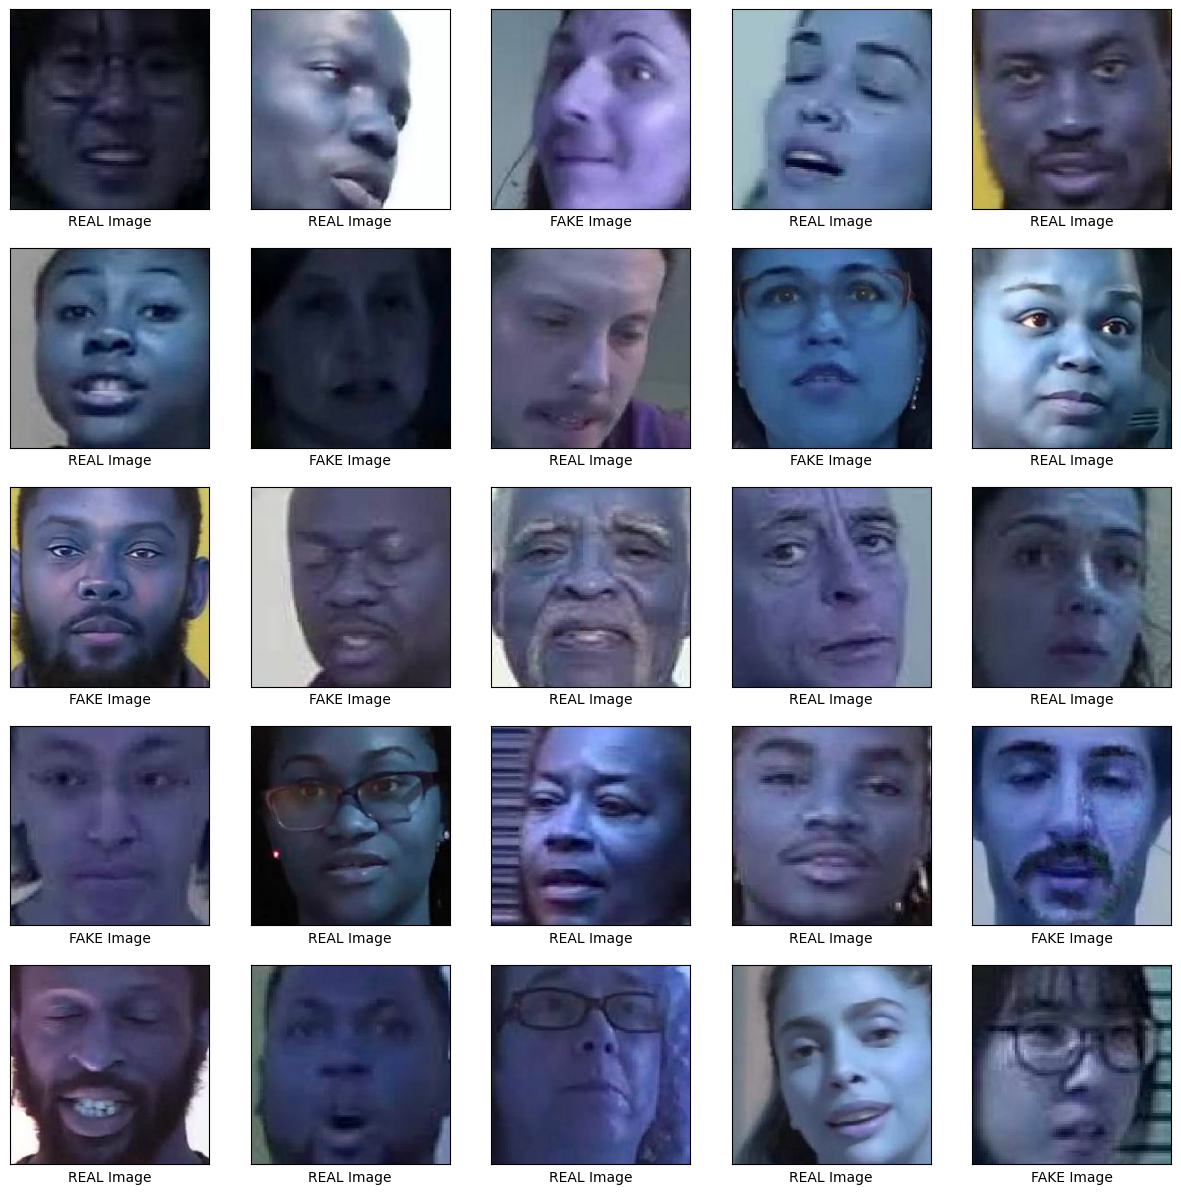

In [10]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

CUSTOM CNN MODEL

In [11]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [12]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [37]:
X_train.shape

(8960, 224, 224, 3)

In [13]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [14]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,619,585 (196.91 MB)

 Trainable params: 51,619,585 (196.91 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,validation_data=(X_val, y_val))

Epoch 1/5


I0000 00:00:1715748917.530857     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715748917.548744     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5014 - loss: 563.6901

W0000 00:00:1715748952.697462     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 90s 282ms/step - accuracy: 0.5014 - loss: 560.6005 - val_accuracy: 0.5148 - val_loss: 0.6942
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.5056 - loss: 0.6961 - val_accuracy: 0.4896 - val_loss: 0.6929
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - accuracy: 0.5183 - loss: 0.6935 - val_accuracy: 0.5148 - val_loss: 0.6928
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.5176 - loss: 0.6935 - val_accuracy: 0.5047 - val_loss: 0.6938
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - accuracy: 0.5161 - loss: 0.6946 - val_accuracy: 0.5096 - val_loss: 0.6970


In [16]:
score = model.evaluate(X_test, y_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.5251 - loss: 0.6964


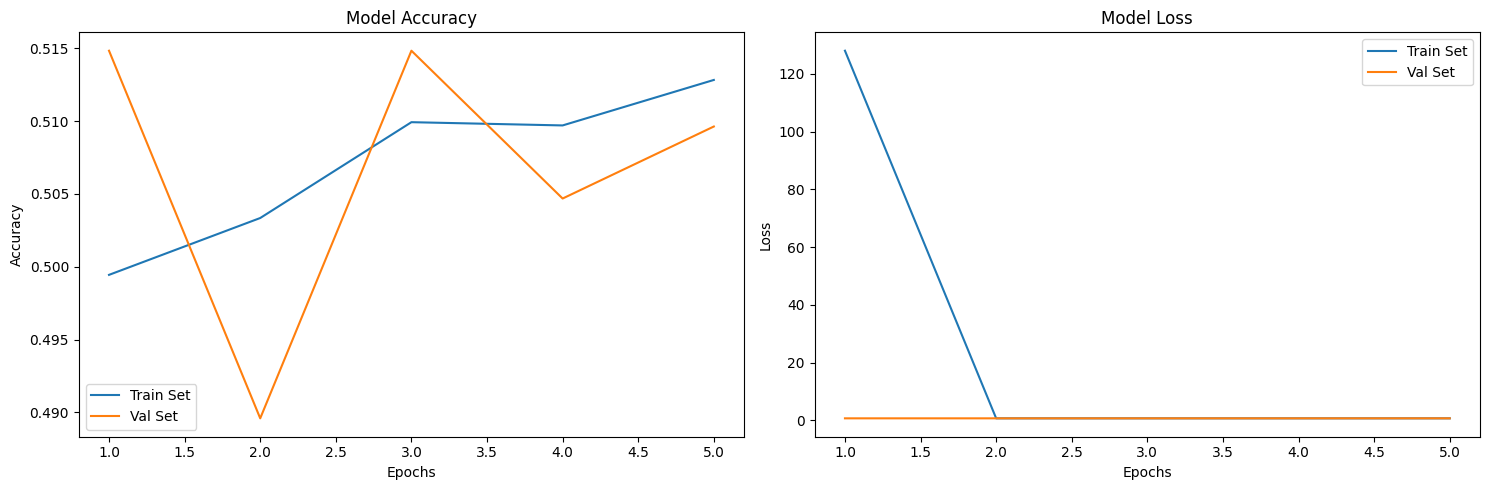

In [17]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

using Inception model for fine-tuning

In [18]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [19]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

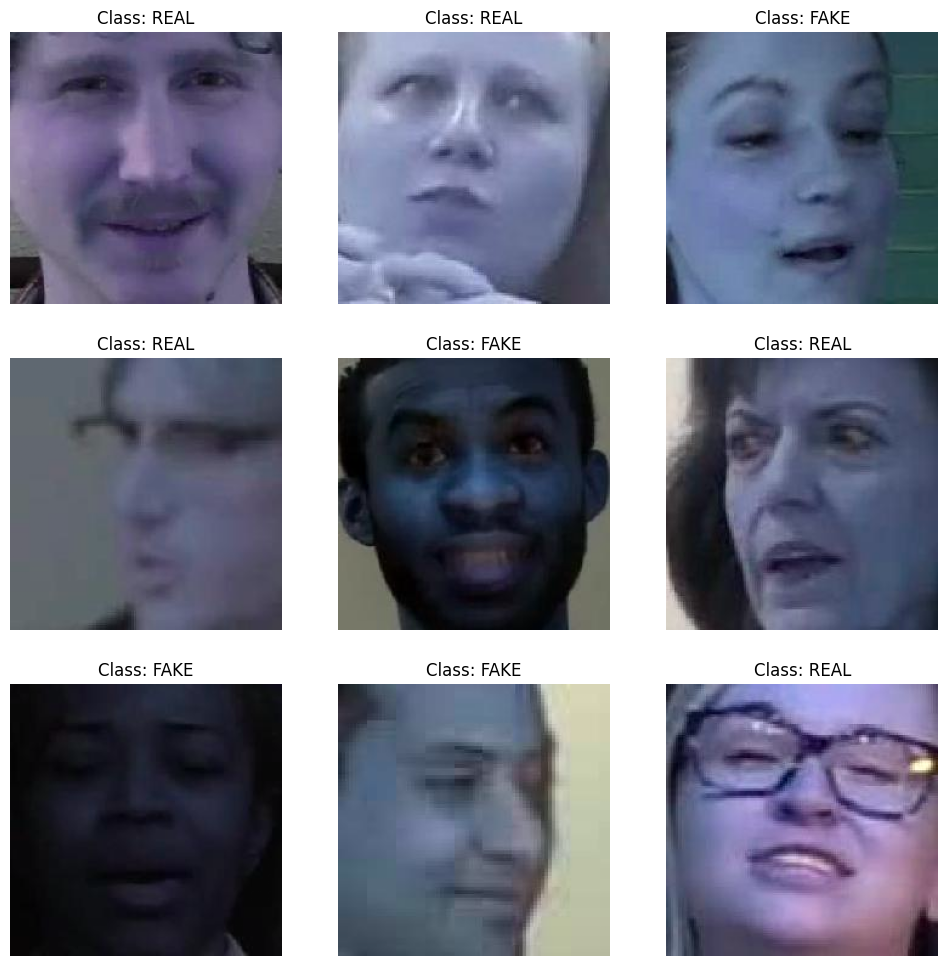

In [20]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [21]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 70s 179ms/step - accuracy: 0.5707 - loss: 0.9238 - val_accuracy: 0.5648 - val_loss: 1.4800
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - accuracy: 0.5935 - loss: 1.0583 - val_accuracy: 0.6419 - val_loss: 0.7580
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 83s 167ms/step - accuracy: 0.6242 - loss: 0.9187 - val_accuracy: 0.6159 - val_loss: 0.9191
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - accuracy: 0.6343 - loss: 0.8761 - val_accuracy: 0.6560 - val_loss: 0.7652
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 46s 165ms/step - accuracy: 0.6682 - loss: 0.7849 - val_accuracy: 0.6279 - val_loss: 0.8727
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - accuracy: 0.6584 - loss: 0.8524 - val_accuracy: 0.5836 - val_loss: 1.1066
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 46s 164ms/step - accuracy: 0.6595 - loss: 0.8223 - val_accuracy: 0.5635 - val_loss: 1.3993
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 46s 164ms/step - accuracy: 0.6459 - loss: 0

In [24]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer            33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [25]:
model.evaluate(test_set)

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.5989 - loss: 1.0962


[1.104770302772522, 0.5931249856948853]

In [26]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 110s 311ms/step - accuracy: 0.5911 - loss: 0.7165 - val_accuracy: 0.6786 - val_loss: 0.6503
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 126s 301ms/step - accuracy: 0.8115 - loss: 0.4175 - val_accuracy: 0.7729 - val_loss: 0.5150
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 84s 300ms/step - accuracy: 0.9175 - loss: 0.1977 - val_accuracy: 0.7586 - val_loss: 0.6786
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 84s 300ms/step - accuracy: 0.9531 - loss: 0.1221 - val_accuracy: 0.7849 - val_loss: 0.7109
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 84s 299ms/step - accuracy: 0.9650 - loss: 0.0959 - val_accuracy: 0.7852 - val_loss: 0.6610
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 84s 299ms/step - accuracy: 0.9766 - loss: 0.0678 - val_accuracy: 0.7935 - val_loss: 0.8580
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 84s 299ms/step - accuracy: 0.9823 - loss: 0.0451 - val_accuracy: 0.8036 - val_loss: 0.7750
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 84s 299ms/step - accuracy: 0.9899 - loss:

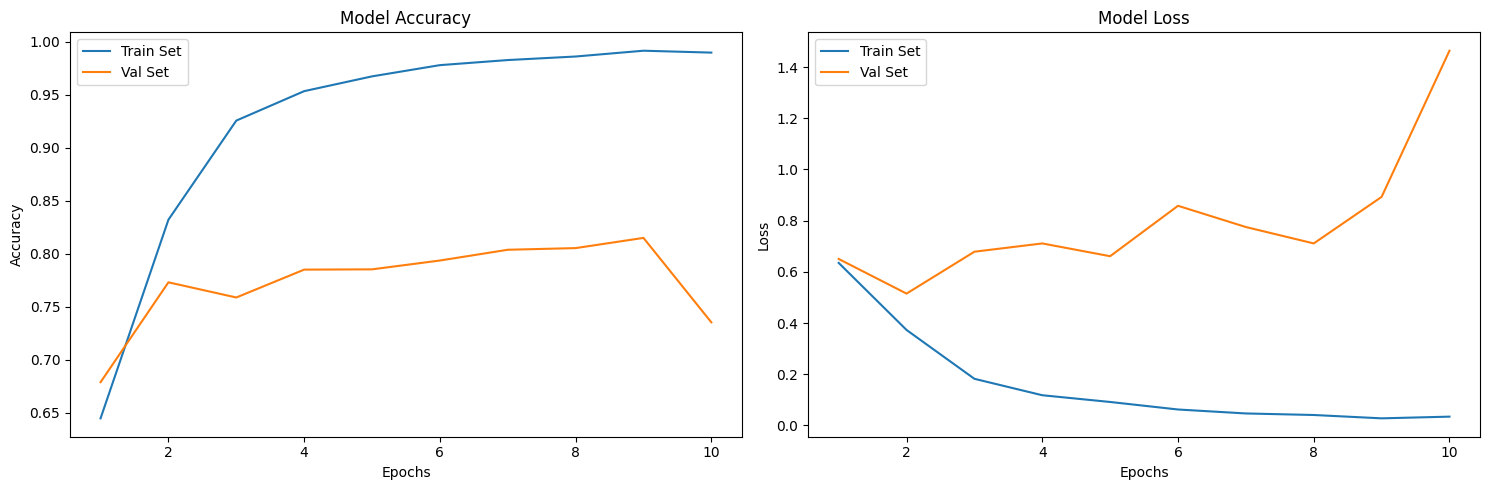

In [27]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [28]:
model.evaluate(test_set)

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.7409 - loss: 1.4008


[1.337693214416504, 0.7506250143051147]